In [29]:
from labs.install_deps import require_think_dsp

require_think_dsp()

thinkdsp.py successfully download


Упражнение 7.1
Позапускаем примеры в блокноте chap07.ipynb.

Упражнение 7.2
Реализовать алгоритм БПФ (ключ к нему - лемма Дэниелсона-Ланцоша) сначала нерекурсивно, а затем рекурсивно.

В качестве тестового примера начнем с небольшого сигнала и вычислим его БПФ.

In [30]:
import numpy as np

ys = [-0.5, 0.1, 0.7, -0.1]
hs = np.fft.fft(ys)
print(hs)

[ 0.2+0.j  -1.2-0.2j  0.2+0.j  -1.2+0.2j]


In [31]:
PI2 = 2 * np.pi

def dft(ys):
    N = len(ys)
    ts = np.arange(N) / N
    freqs = np.arange(N)
    args = np.outer(ts, freqs)
    M = np.exp(1j * PI2 * args)
    amps = M.conj().transpose().dot(ys)
    return amps

Подтвердим, что эта реализация дает тот же результат.

In [32]:
hs2 = dft(ys)
np.sum(np.abs(hs - hs2))

5.864775846765962e-16

В качестве приближения к созданию рекурсивного БПФ начнем с версии, которая разбивает входной массив и использует np.fft.fft для вычисления БПФ половин.

In [33]:
def fft_norec(ys):
    N = len(ys)
    He = np.fft.fft(ys[::2])
    Ho = np.fft.fft(ys[1::2])

    ns = np.arange(N)
    W = np.exp(-1j * PI2 * ns / N)

    return np.tile(He, 2) + W * np.tile(Ho, 2)

Получаем те же результаты.

In [34]:
hs3 = fft_norec(ys)
np.sum(np.abs(hs - hs3))

0.0

Мы можем заменить np.fft.fft рекурсивными вызовами и добавить базовый вариант.

In [35]:
def fft(ys):
    N = len(ys)
    if N == 1:
        return ys

    He = fft(ys[::2])
    Ho = fft(ys[1::2])

    ns = np.arange(N)
    W = np.exp(-1j * PI2 * ns / N)

    return np.tile(He, 2) + W * np.tile(Ho, 2)

Получаем те же результаты.

In [36]:
hs4 = fft(ys)
np.sum(np.abs(hs - hs4))

1.6653345369377348e-16

Эта реализация БПФ занимает время, пропорциональное nlogn . Также занимает память, пропорциональную nlogn, и тратит некоторое время на создание и копирование массивов. Его можно улучшить для запуска "на месте"; в этом случае он не требует дополнительной памяти и тратит меньше времени на "накладные расходы".

**Теорема о сдвиге**

Если дан смещенный во времени сигнал $s(t-t0)$ (запаздывание на t0), то Фурье–преобразование от этого сигнала будет:
$F[s(t-t0)] = e^{-jwt0} S(jw)$, где
$S(jw) = F[s(t)]$

Таким образом, смещенный сигнал имеет спектральную плотность, отличающуюся лишь спектральной плотностью фаз.


**Теорема о свертке**

Преобразование Фурье от свертки двух функций можно представить как произведение преобразований Фурье каждой из функцй:
$F[g*h] = F[g]F[h]$

Спектр свертки сигналов равен произведению спектров.

**Вывод преобразования Фурье**

Отобразим исходный сигнал на комплексную плоскость. Это позволяет рассматривать точки на плоскости как комплексные числа и использовать формулу Эйлера для описания намотки:

In [37]:
from cmath import cos, sin

def ei(phi):
    return cos(phi) + 1j * sin(phi)

Геометрически это соотношение означает, что при любом φ точка eiφ на комплексной плоскости лежит на единичной окружности.
Построим радиус-вектор eiφ при разных значениях φ.

In [38]:
phis = np.arange(0, PI2, 0.001)
complex_plane = [ei(phi) for phi in phis]

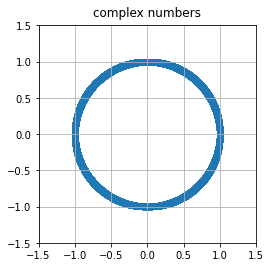

In [39]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter([z.real for z in complex_plane], [z.imag for z in complex_plane])
ax.grid(True)
ax.set_aspect('equal', adjustable='box')
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)

ax.set_title("complex numbers", va='bottom')
plt.show()

При изменении φ на 2π вектор проходит полный оборот против часовой стрелки, так как 2π – длина единичной окружности. Чтобы задать скорость вращения вектора, показатель степени домножаем на ft, а для смены направления вращения – на -1.

Тогда намотка сигнала:

In [40]:
def signal_winding(ys, t, f): return ys[t] * ei(-PI2 * f * t)

Теперь вычисляем центр масс. Для этого отметим i произвольных точек на графике намотки и вычислим среднее:

In [41]:
def mass_center(ys, f):
    return np.mean([signal_winding(ys, i, f) for i in range(len(ys))])